# MHC-Motifs

In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib as mpl

import matplotlib.colors as mcolors

In [2]:
import logomaker as lm

## Settings

In [3]:
TEXTWIDTH = 6.7261  # in
DPI = 360

In [4]:
def set_font_size(font_size):
    plt.rc('font', size=font_size)          # controls default text sizes
    plt.rc('axes', titlesize=font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=font_size)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=font_size, title_fontsize=font_size)    # legend fontsize
    plt.rc('figure', titlesize=font_size)   # fontsize of the figure title

In [5]:
sb.set(context='paper', style='whitegrid')
plt.rc('grid', linewidth=0.3)
sb.set_palette('colorblind')
set_font_size(6)

In [6]:
cmap_distances = 'viridis_r'
palette_pos = sb.color_palette('Set2', 9)#[2:]

## Paths

In [7]:
path_data = '../data'
path_h2kb = f'{path_data}/data_classI_MS_Peptides_H2-Kb.txt'

## Read Data
### MHC Altas motives 
downloaded from http://mhcmotifatlas.org/ on 12.03.2024

In [8]:
def read_mhc_motifs(hla, length):
    df_mhc = pd.read_csv(f'{path_data}/data_classI_MS_Peptides_{hla}.txt', header=None)
    df_mhc = df_mhc[df_mhc[0].str.len() == length]
    df_mhc = df_mhc[0].apply(lambda x: pd.Series(list(x)))
    df_mhc.columns = [el for el in df_mhc.columns]
    df_mhc = df_mhc.apply(pd.value_counts).transpose() / len(df_mhc)
    df_mhc = df_mhc.fillna(0.0)
    df_mhc = lm.transform_matrix(df_mhc, from_type='probability', to_type='information')
    return df_mhc

df_h2kb = read_mhc_motifs('H2-Kb', 8)
df_cmv = read_mhc_motifs('A0201', 9)
df_tumor = read_mhc_motifs('B0702', 9)

In [9]:
dfs_mhc = {
    'H2-Kb': df_h2kb,
    'HLA-A02*01': df_cmv,
    'HLA-B07*02': df_tumor, 
}

## Anchor positions
As defined by IEDB accessed 12.03.2024 (https://www.iedb.org/mhc/122, https://www.iedb.org/mhc/143, https://www.iedb.org/mhc/251). H2-Kb adapted to other sources.

In [10]:
anchor_positions = {
    'H2-Kb': [3, 5, 8],
    'HLA-A02*01': [2, 9],
    'HLA-B07*02': [2, 9],
}

epitopes = {
    'H2-Kb': 'SIINFEKL',
    'HLA-A02*01': 'NLVPMVATV',
    'HLA-B07*02': 'VPSVWRSSL',
}

## Distances

In [11]:
tcrs_by_epitope = {
    'SIINFEKL': ['Ed21', 'OT1', 'Ed8', 'Ed161', 'Ed1630', 'B11',
                 'B15', 'Ed46', 'Ed45', 'Ed9', 'Ed33', 'Ed28', 'Ed39',
                 'Ed31', 'B3', 'F4', 'E8', 'B13', 'H6', 'G6', 'F5', 'B10', 'H5', 'B16',
                 'B2', 'B14', 'E4', 'B6', 'B7', 'G2', 'B5', 'E9'],
    'NLVPMVATV': ['TCR77-14', 'TCR81-14', 'TCR65-8', 'TCR73-14', 'TCR6-2', 'TCR5-2',
                  'TCR83-3', 'TCR10-4', 'TCR11-4', 'TCR82-14', 'TCR84-3', 'TCR66-8',
                  'TCR3-4', 'TCR54-10', 'TCR52-10', 'TCR1-4', 'TCR74-14', 'TCR4-4',
                  'TCR2-4', 'TCR51-10'],
    'VPSVWRSSL': ['R21', 'R23', 'R24', 'R25', 'R26', 'R28']
}

In [12]:
def load_3D_distances(epitope='SIINFEKL'):
    path_in = '../results/model3d/3D_'
    if epitope == 'NLVPMVATV':
        path_in += 'cmv'    
    elif epitope == 'VPSVWRSSL':
        path_in += 'tumor'
    else:
        path_in += 'SIINFEKL'
    
    tcrs = tcrs_by_epitope[epitope]
    
    distances_alpha = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_alpha.csv', index_col=0) for tcr in tcrs}
    distances_beta = {tcr: pd.read_csv(f'{path_in}/{tcr}_{epitope}_beta.csv', index_col=0) for tcr in tcrs}
    
    min_epitope_distances = []
    for tcr in distances_alpha.keys():
        min_distances = np.stack([distances_alpha[tcr].values.min(axis=1), distances_beta[tcr].values.min(axis=1)])
        min_distances = np.min(min_distances, axis=0)
        min_epitope_distances.append(min_distances)
    return np.mean(min_epitope_distances, axis=0).reshape((-1, 1)).T

distances = {
    'H2-Kb': load_3D_distances('SIINFEKL'),
    'HLA-A02*01': load_3D_distances('NLVPMVATV'),
    'HLA-B07*02': load_3D_distances('VPSVWRSSL'),
}

In [13]:
min_dist = min([np.min(el) for el in distances.values()])
max_dist = max([np.max(el) for el in distances.values()])

## Raw Data

In [14]:
def read_mice_subset(is_educated, normalization='AS'):
    if is_educated:
        path_in = '../data/Affinity_prediction_educated_repertoire.xlsx'
    else:
        path_in = '../data/Affinity_prediction_naive_repertoire.xlsx'
    if normalization == 'AS':
        df = pd.read_excel(path_in, 'Normalized data', skiprows=1)
    else:
        df = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    #columns = df.columns
    #tcrs = columns[::4]
    #columns = columns[3::4]
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df_pos = pd.read_excel(path_in, 'Individual APL screening', skiprows=1)
    df_pos.loc[152, 'Position'] = 0
    df['Mutated_position'] = df_pos['Position']
    df = df.drop(columns=['Sequence', 'Amino Acid', 'Position', 'APL'], errors='ignore')
    return df

In [15]:
def read_mice_data(normalization='AS'):
    data_naive = read_mice_subset(False, normalization=normalization)
    data_educated = read_mice_subset(True, normalization=normalization)
    
    data_joint = pd.concat([data_naive, data_educated], axis=1, join='inner')
    order = list(data_joint.columns)
    order.remove('OTI')
    order = ['OTI'] + [x for x in order if x.startswith('Ed')] + [x for x in order if not x.startswith('Ed')]
    data_joint = data_joint[order]
    data_joint.index = [f'{i//19 + 1}_{i%19}' for i in range(len(data_joint))]
    data_joint = data_joint.rename(index={'9_0': '0_0'})
    
    data_joint = data_joint[[col for col in data_joint.columns if col != 'Mutated_position']]
    cols = ['Ed21', 'OTI', 'Ed8', 'Ed16-1', 'Ed16-30', 'B11',
                 'B15', 'Ed46', 'Ed45', 'Ed9', 'Ed33', 'Ed28', 'Ed39',
                 'Ed31', 'B3', 'F4', 'B13', 'G6', 'F5', 'H5',]
    data_joint = data_joint[cols]
    return data_joint

In [16]:
def read_human_data(normalization='pc'):
    path_in = '../data/Affinity_prediction_rnf43_repertoire.xlsx'
    sheet = 'Normalized by PC'
    if normalization != 'pc':
        sheet = 'Individual APL screening'
    df = pd.read_excel(path_in, sheet)
    df['Mutated_position'] = df['Mutated_position'].replace({'VPSVWRSSL': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Peptide', 'Mutated_position', 'Peptide ID', 'Mutated AA'])
    df = df.drop(['R27'], axis=1)
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    return df

In [17]:
def read_cmv_data():
    path_in = '../data/Affinity_prediction_cmv.xlsx'
    sheet = 'Mean'
    df = pd.read_excel(path_in, sheet)
    
    df_pep = pd.read_excel(path_in, 'peptides',)
    df['Mutated_position'] = df_pep['Mutated Position']
    df['Mutated AA'] = df_pep['Amino acid']
    
    df['Mutated_position'] = df['Mutated_position'].replace({'NLVPMVATV': 0})
    df['Mutated AA'] = df['Mutated AA'].replace({'original': 0})
    df = df[[el for el in df.columns if not el.startswith('Unnamed')]]
    
    df.index = df['Mutated_position'].astype(str) + '_' + df['Mutated AA'].astype(str)
    df = df.drop(columns=['Mutated_position', 'Mutated AA', 'Peptide_ID'])
    df = df.reindex(df.index[1:].tolist() + df.index[:1].tolist())
    sorted_columns = df.loc['0_0'].sort_values(ascending=False)
    df = df[sorted_columns.index]
    return df

In [18]:
raw_data = {
    'H2-Kb': read_mice_data(normalization='AS'),
    'HLA-A02*01': read_cmv_data(),
    'HLA-B07*02': read_human_data(normalization='pc'),
}

# Plotting functions

In [19]:
title_map = {
    'H2-Kb': 'H-2K$^{b}$', 
    'HLA-B07*02': 'HLA-B*07:02', 
    'HLA-A02*01': 'HLA-A*02:01'
}

In [20]:
def plot_motif(mhc, ax):
    df = dfs_mhc[mhc].copy()   
    logo = lm.Logo(df, stack_order='big_on_top', color_scheme='chemistry', font_name='Arial Rounded MT Bold', ax=ax, )
    
    for p in anchor_positions[mhc]:
        logo.highlight_position_range(pmin=p-1, pmax=p-1, color='cornsilk')
    sb.despine(ax=ax)
    ax.set_ylabel('Bits', labelpad=1)
    ax.set_xlabel('', labelpad=0)
    logo.ax.set_xticks(range(df.shape[0]))
    logo.ax.set_xticklabels([f'P{i+1}' for i in range(df.shape[0])])
    ax.set_title(title_map[mhc])
    ax.grid(False)
    ax.tick_params(axis='both', length=0, pad=3)
    
    epitope = epitopes[mhc]
    ax2 = ax.twiny()
    ax2.set_xticks([(i+0.5)-i/len(epitope) for i in range(len(epitope))])  
    ax2.set_xticklabels([l for l in epitope])
    ax2.tick_params(axis='x', which='both', bottom=False, top=True)
    sb.despine(ax=ax2)
    ax2.grid(False)
    ax2.tick_params(axis='x', length=0, pad=0)
    ax2.set_xlim(0, len(epitope)-1)

In [21]:
def plot_distances(mhc, ax):
    dist = distances[mhc]    
    x_labels = [f'P{i + 1}' for i in range(dist.shape[1])]
    plot = sb.heatmap(dist, square=True, ax=ax,
                       vmin=min_dist, vmax=max_dist, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False)
    plot.set_xlabel('Position', labelpad=0)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, rotation=0)
    ax.tick_params(bottom=True, width=0.75, length=3)

In [22]:
def plot_cbar(ax):
    ax.axis('off')
    norm = mcolors.Normalize(vmin=min_dist, vmax=max_dist)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, 
                      ax=[ax], orientation='horizontal')
    cb.set_label('Distance in Å')

In [23]:
def plot_empty(ax):
    ax.axis('off')

In [24]:
def plot_activation(mhc, ax):
    df = raw_data[mhc]
    df = pd.DataFrame(df.mean(axis=1), columns=['Activation'])
    df = df[df.index != '0_0']
    wt = df['Activation'].mean() #df.loc['0_0', 'Activation']
  
    df['Position'] = df.index.str.split('_').str[0]
    
    sb.stripplot(data=df, x='Position', y='Activation', ax=ax, size=2, 
                 order=[str(el+1) for el in range(df['Position'].astype(int).max())],
                 palette=palette_pos)  
    ax.axhline(y=wt, color='silver', linestyle='--')

    sb.despine(ax=ax)
    ax.set_ylabel('Activation', labelpad=1)
    ax.set_xlabel('', labelpad=0)
    ax.set_xticklabels([f'P{i+1}' for i in range(df['Position'].astype(int).max())])
    ax.grid(False)
    ax.tick_params(axis='both', length=0, pad=3)

# Figure

<ipython-input-25-ee9e34f193c0>:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


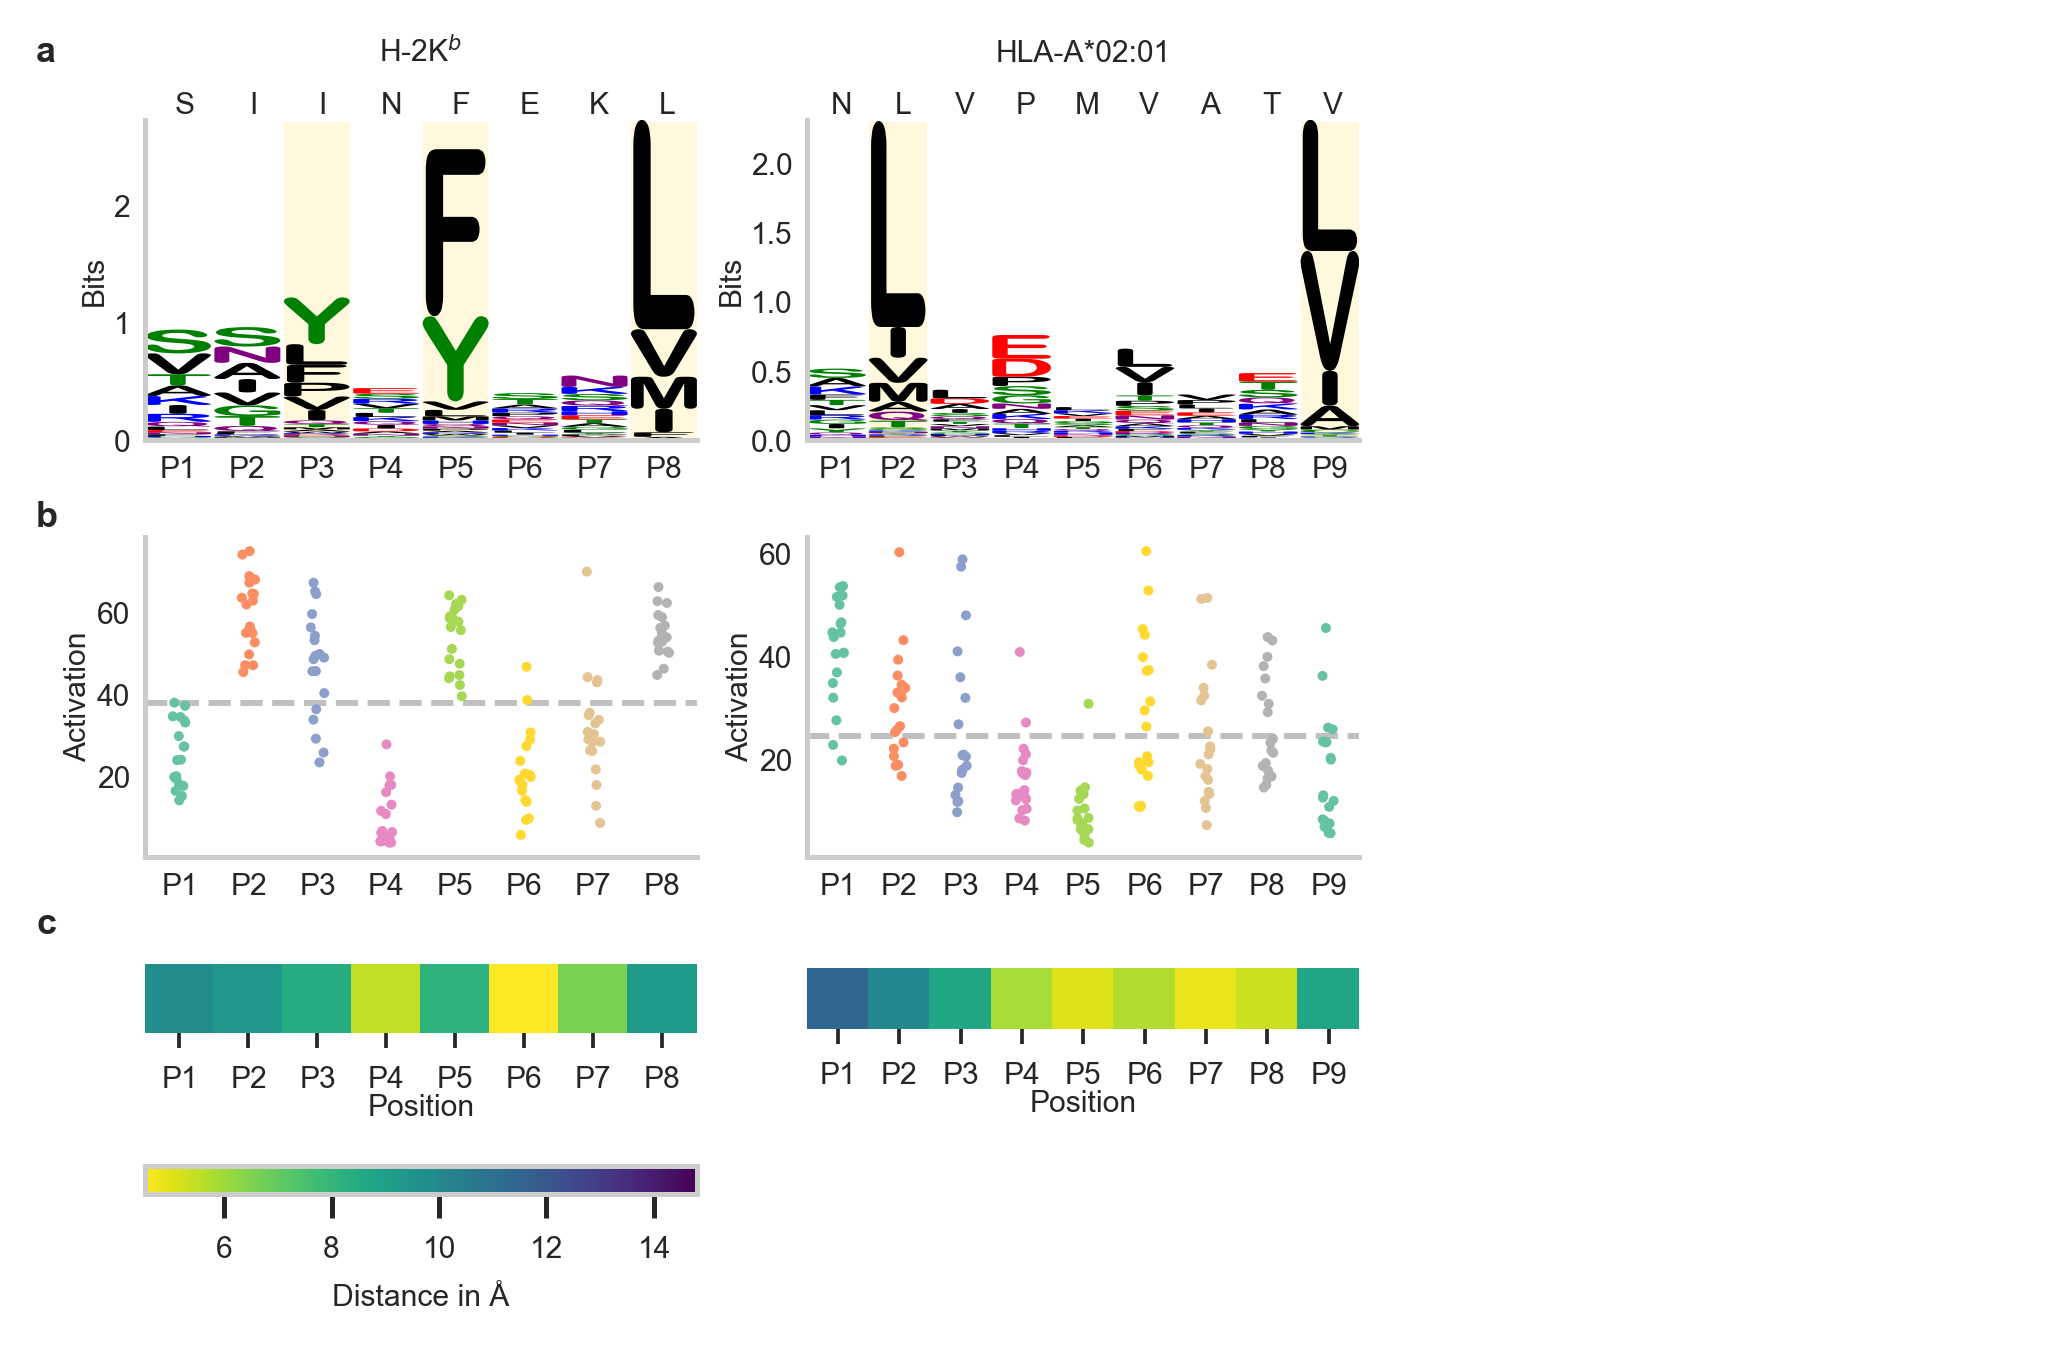

In [25]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[2, 1.5],
    hspace=-0.3
)

gridspecs['1-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=2,
    ncols=3,
    height_ratios=[1, 1],
    width_ratios=[1, 1, 1],
    hspace=0.3
)

gridspecs['7-12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1],
    nrows=2,
    ncols=3,
    height_ratios=[1, 0.5],
    width_ratios=[1, 1, 1,],
    hspace=-0.9
)

for i, mhc in enumerate(['H2-Kb', 'HLA-A02*01',]):
    ax = fig.add_subplot(gridspecs['1-6'][i])
    plot_motif(mhc, ax)
    
    ax = fig.add_subplot(gridspecs['1-6'][i+3])
    plot_activation(mhc, ax)
    
    ax = fig.add_subplot(gridspecs['7-12'][i])
    plot_distances(mhc, ax)
    
    ax = fig.add_subplot(gridspecs['7-12'][i+3])
    if i == 0:
        plot_cbar(ax)
    else:
        plot_empty(ax)

ax = fig.add_subplot(gridspecs['1-6'][2])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['1-6'][5])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][2])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][5])
plot_empty(ax)
    
fig.text(0.08, 0.92, 'a', size='large', weight='bold')
fig.text(0.08, 0.6, 'b', size='large', weight='bold')
fig.text(0.08, 0.32, 'c', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_mhcMotifs.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_mhcMotifs.png', dpi=DPI, bbox_inches='tight')

In [26]:
raw_data['HLA-A02*01'][raw_data['HLA-A02*01'].index.str.split('_').str[0]=='9'
                      ].mean(axis=1).sort_values(ascending=False)

9_Y    45.541403
9_C    36.242022
9_M    26.178218
9_I    25.853893
9_A    23.500191
9_H    23.370689
9_K    23.290756
9_F    20.305124
9_G    19.959582
9_N    13.029094
9_R    12.597805
9_E    11.947161
9_P    10.778304
9_Q     8.355104
9_S     8.090795
9_W     7.557219
9_D     6.900070
9_T     5.729934
9_L     5.660177
dtype: float64

In [27]:
raw_data['HLA-A02*01'][raw_data['HLA-A02*01'].index.str.split('_').str[0]=='2'
                      ].mean(axis=1).sort_values(ascending=False)

2_M    60.268112
2_N    43.171823
2_K    39.382788
2_W    36.301448
2_C    34.517096
2_H    33.887210
2_V    33.438015
2_E    32.991090
2_R    32.043144
2_I    29.978528
2_G    26.462551
2_F    25.782325
2_Y    25.314834
2_P    23.295364
2_D    22.086081
2_S    20.601200
2_A    18.958301
2_T    18.762269
2_Q    16.785528
dtype: float64

## SFig MHC Mice

<ipython-input-28-d5b4ecc60e88>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


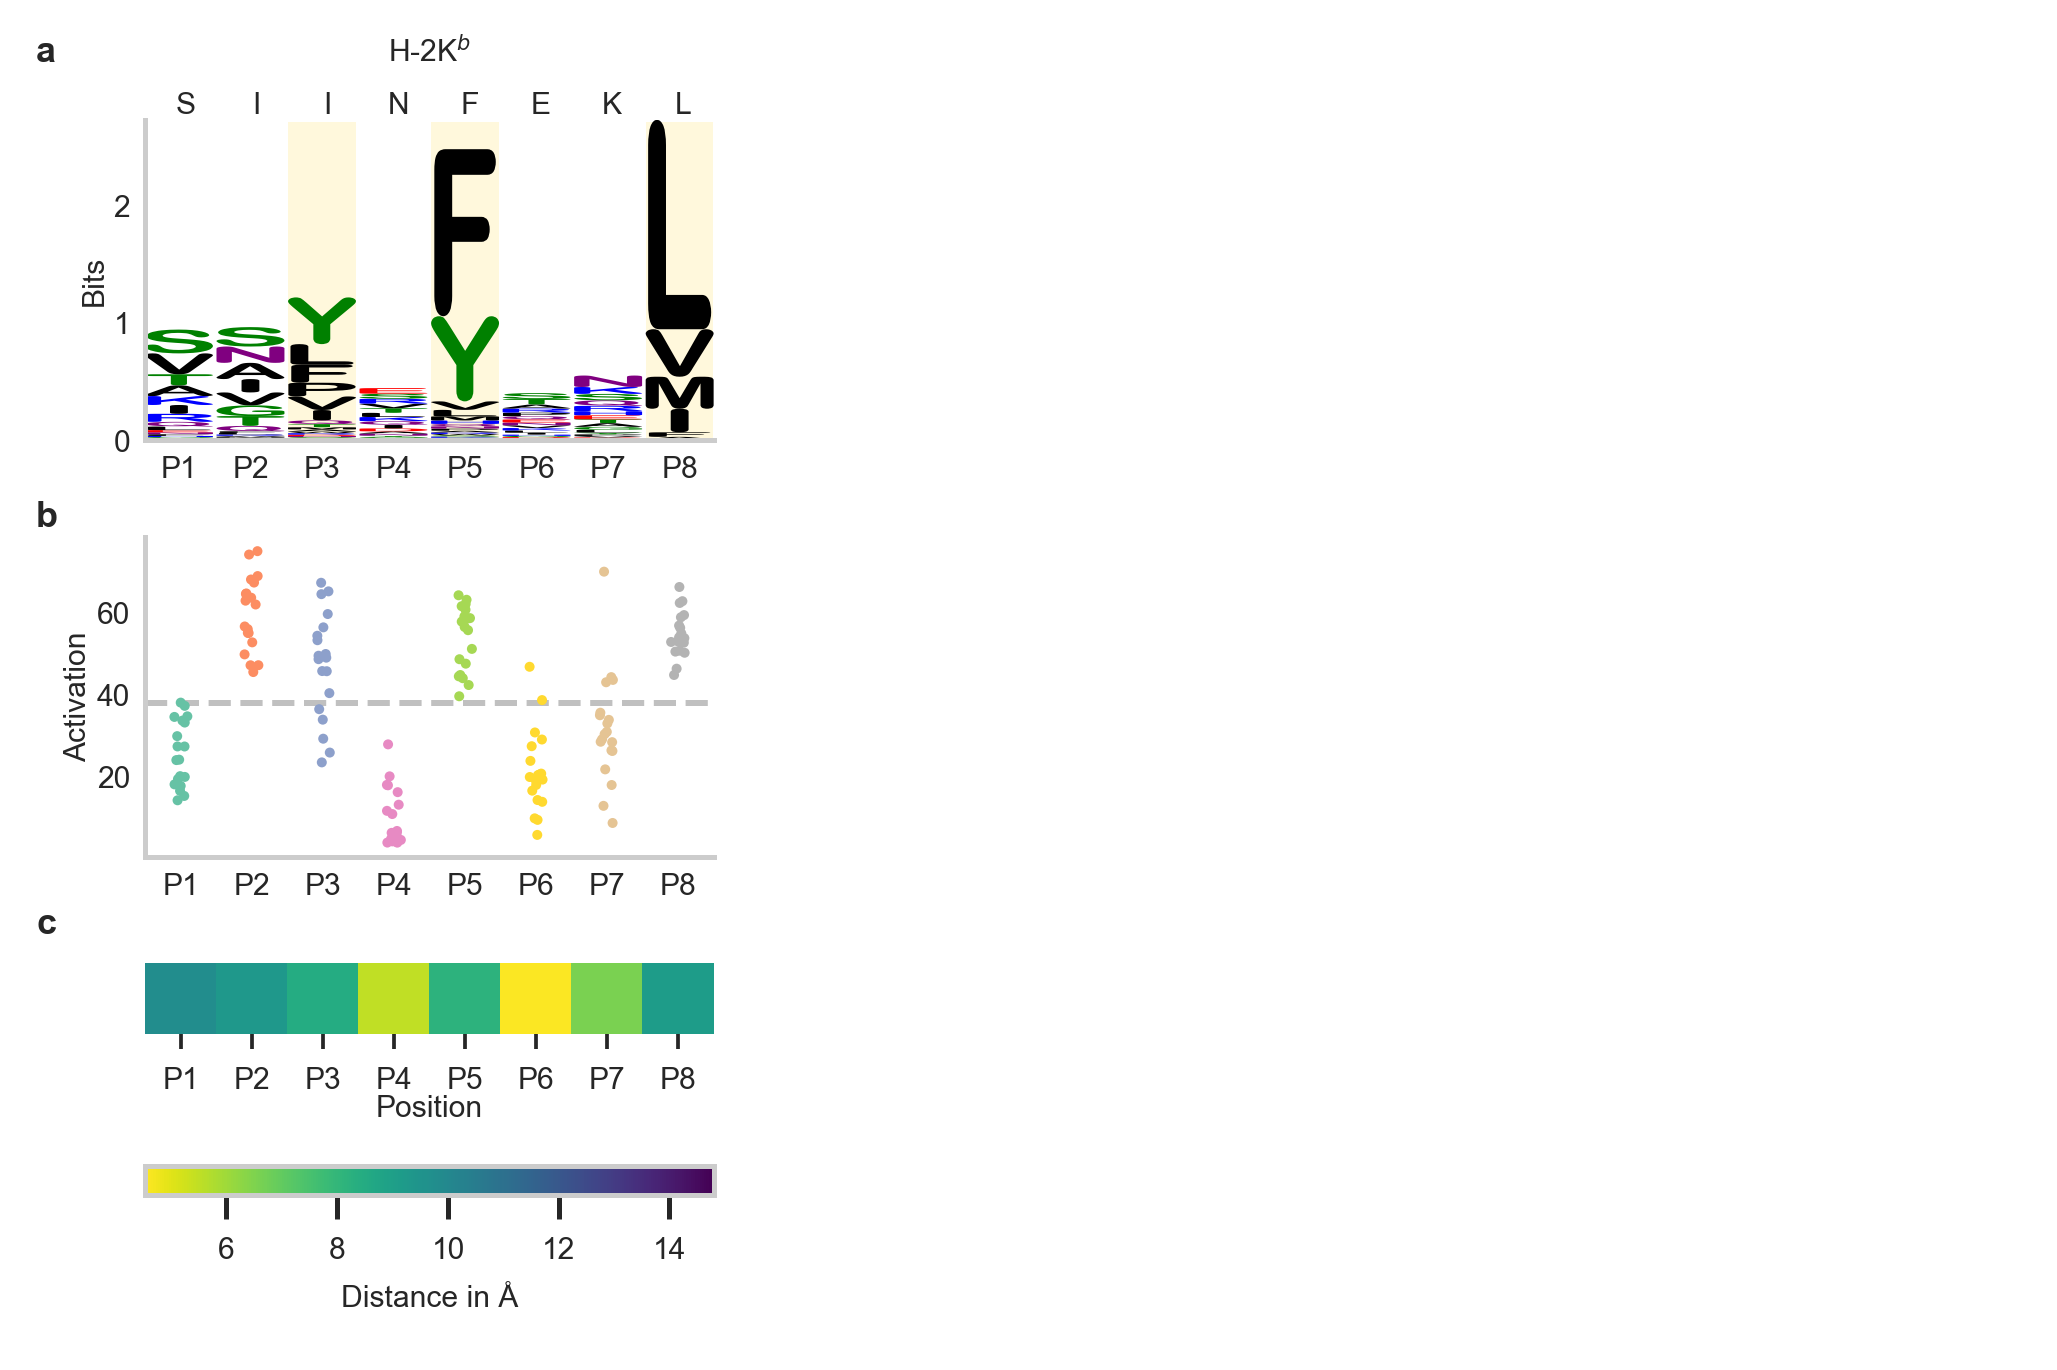

In [28]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[2, 1.5],
    hspace=-0.3
)

gridspecs['1-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 2],
    hspace=0.3
)

gridspecs['7-12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1],
    nrows=2,
    ncols=2,
    height_ratios=[1, 0.5],
    width_ratios=[1, 2],
    hspace=-0.9
)

mhc = 'H2-Kb'
ax = fig.add_subplot(gridspecs['1-6'][0])
plot_motif(mhc, ax)
ax = fig.add_subplot(gridspecs['1-6'][2])
plot_activation(mhc, ax)
ax = fig.add_subplot(gridspecs['7-12'][0])
plot_distances(mhc, ax)
ax = fig.add_subplot(gridspecs['7-12'][2])
plot_cbar(ax)

ax = fig.add_subplot(gridspecs['1-6'][1])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['1-6'][3])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][1])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][3])
plot_empty(ax)
    
    
fig.text(0.08, 0.92, 'a', size='large', weight='bold')
fig.text(0.08, 0.6, 'b', size='large', weight='bold')
fig.text(0.08, 0.32, 'c', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_mhcMotifs_murine.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_mhcMotifs_murine.png', dpi=DPI, bbox_inches='tight')

<ipython-input-29-12dbf38a4146>:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


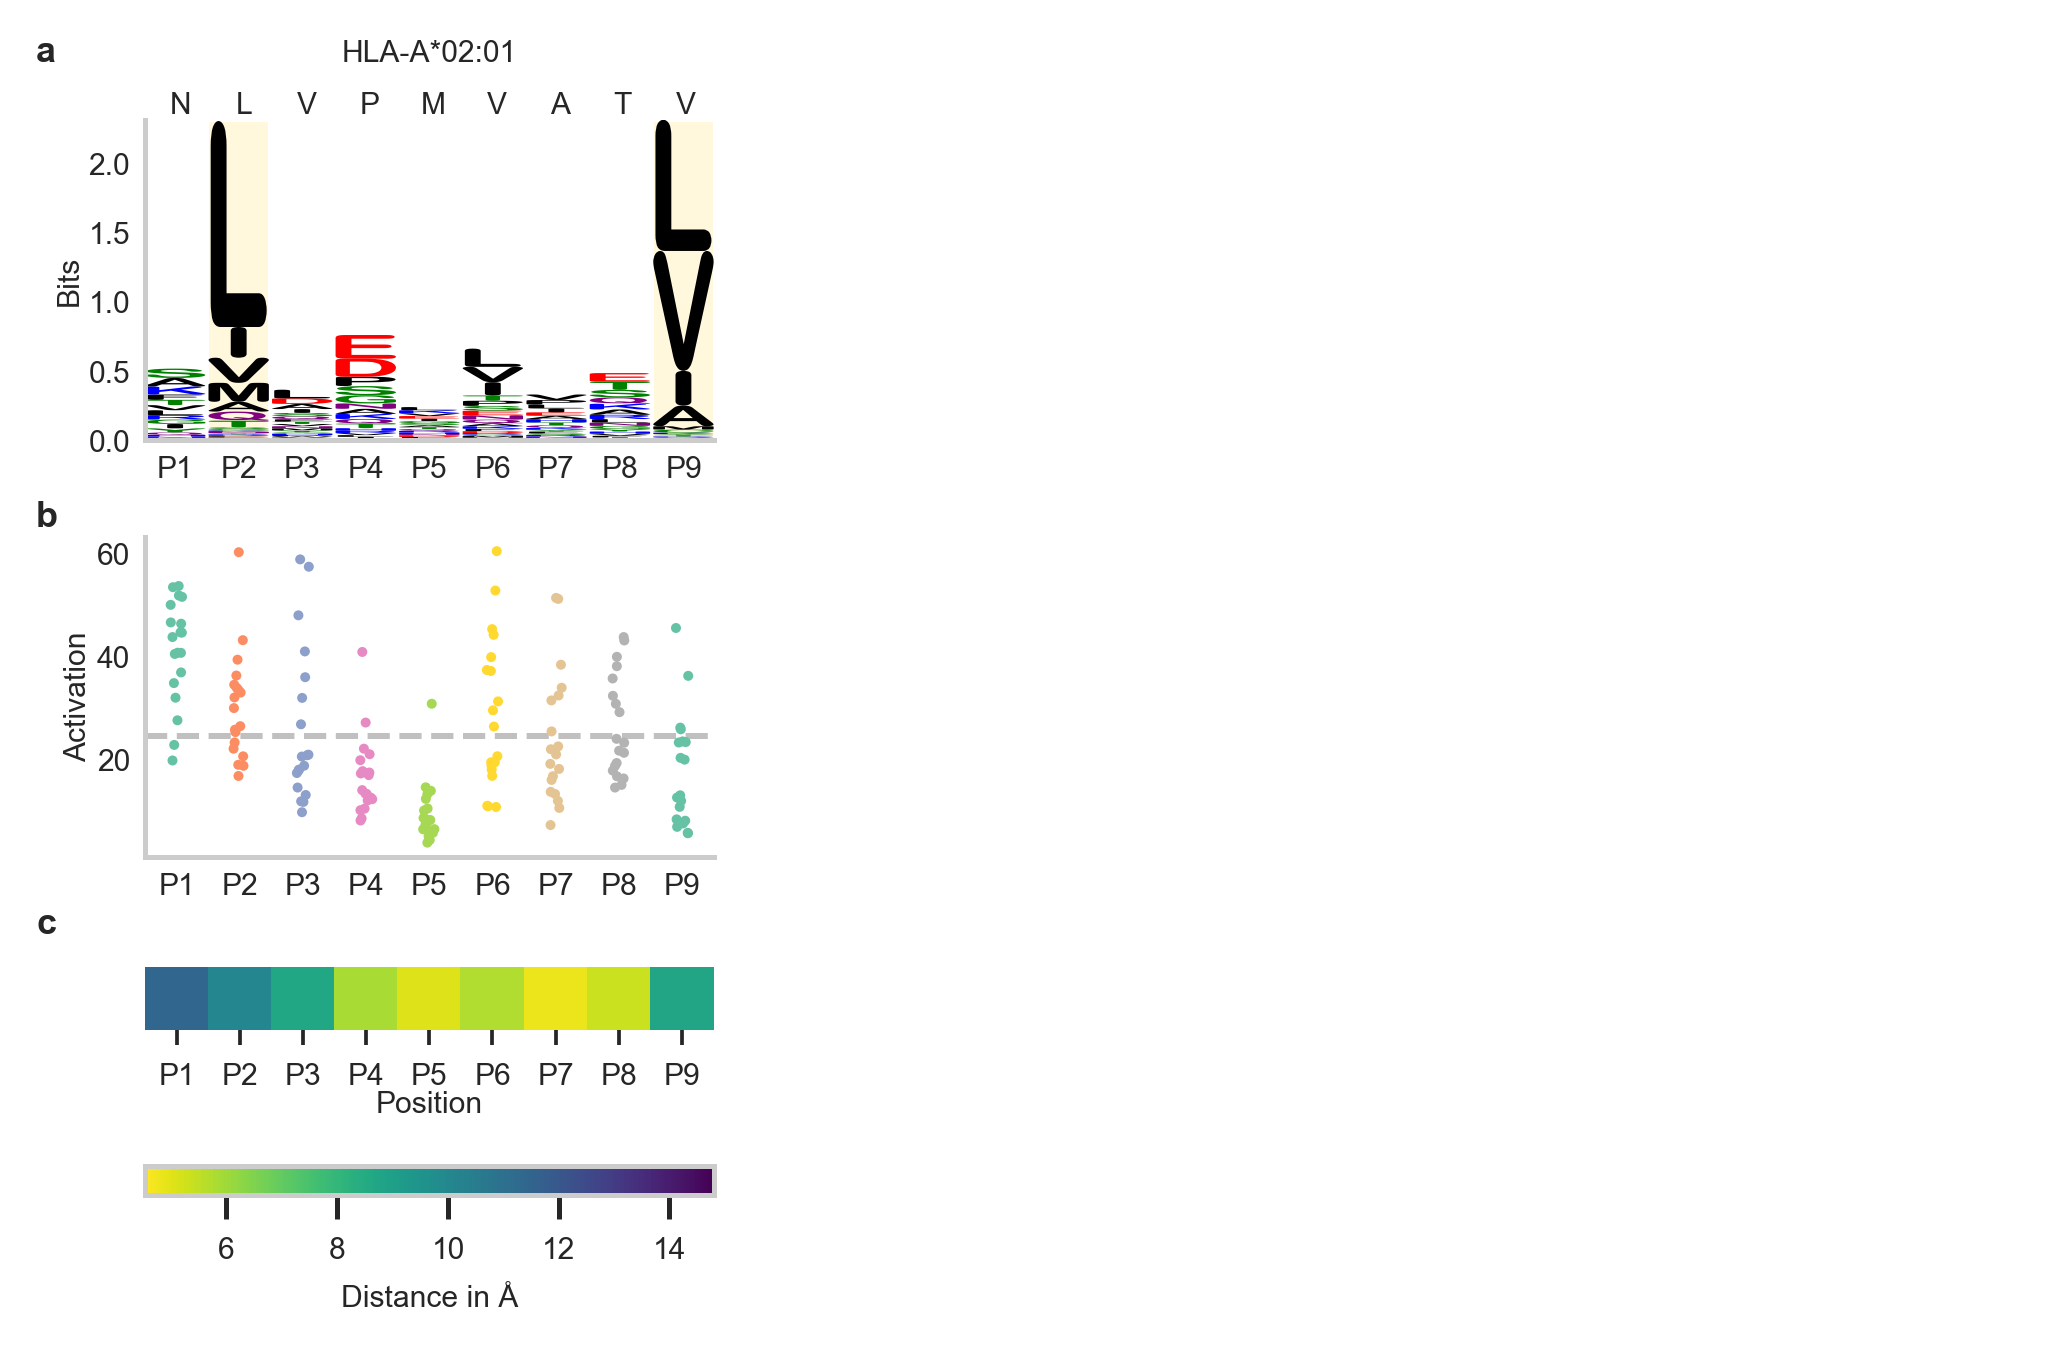

In [29]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.6), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=2,
    ncols=1,
    height_ratios=[2, 1.5],
    hspace=-0.3
)

gridspecs['1-6'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[0],
    nrows=2,
    ncols=2,
    height_ratios=[1, 1],
    width_ratios=[1, 2],
    hspace=0.3
)

gridspecs['7-12'] = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1],
    nrows=2,
    ncols=2,
    height_ratios=[1, 0.5],
    width_ratios=[1, 2],
    hspace=-0.9
)

mhc = 'HLA-A02*01'
ax = fig.add_subplot(gridspecs['1-6'][0])
plot_motif(mhc, ax)
ax = fig.add_subplot(gridspecs['1-6'][2])
plot_activation(mhc, ax)
ax = fig.add_subplot(gridspecs['7-12'][0])
plot_distances(mhc, ax)
ax = fig.add_subplot(gridspecs['7-12'][2])
plot_cbar(ax)

ax = fig.add_subplot(gridspecs['1-6'][1])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['1-6'][3])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][1])
plot_empty(ax)
ax = fig.add_subplot(gridspecs['7-12'][3])
plot_empty(ax)
    
    
fig.text(0.08, 0.92, 'a', size='large', weight='bold')
fig.text(0.08, 0.6, 'b', size='large', weight='bold')
fig.text(0.08, 0.32, 'c', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_mhcMotifs_cmv.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_mhcMotifs_cmv.png', dpi=DPI, bbox_inches='tight')

## Correlation Gini vs Activation

In [30]:
from scipy.stats import pearsonr, spearmanr

def correlate_ic_activation(mhc):
    activation = raw_data[mhc]
    activation = pd.DataFrame(activation[activation.index != '0_0'].mean(axis=1), columns=['activation'])
    activation['position'] = activation.index.str.split('_').str[0]
    activation = activation.groupby('position')['activation'].mean()
    activation.index = activation.index.astype(int)
    
    ic = dfs_mhc[mhc].copy()
    ic.index = ic.index + 1
    ic = ic.sum(axis=1)
    ic.name = 'IC'
    
    df = pd.concat([activation, ic], axis=1)
    
    pearson_corr, pearson_pval = pearsonr(df['activation'], df['IC'])
    spearman_corr, spearman_pval = spearmanr(df['activation'], df['IC'])
    print(f'Pearson: {pearson_corr:.3f} - pval: {pearson_pval:.3f}')
    return df

df_corr_h2kb = correlate_ic_activation('H2-Kb')
df_corr_h2kb

Pearson: 0.712 - pval: 0.047


,activation,IC
1,25.612320,0.944596
2,59.711632,0.965653
3,47.248465,1.218717
4,10.253216,0.445494
5,53.646434,2.482163
6,21.343061,0.403016
7,31.583045,0.552822
8,54.649317,2.732693


In [31]:
df_corr_a02 = correlate_ic_activation('HLA-A02*01')
df_corr_a02

Pearson: 0.006 - pval: 0.987


,activation,IC
1,41.192075,0.518809
2,30.211985,2.308200
3,26.071512,0.366524
4,16.591360,0.761612
5,9.694160,0.240883
6,28.961576,0.663448
7,24.027332,0.331877
8,26.407745,0.486530
9,17.625660,2.317154


### Correlation plot

In [32]:
def plot_correlation(df, ax):
    palette_pos = sb.color_palette('bright', 10)
    palette_pos = dict(zip([f'P{i}' for i in range(1, 10)], palette_pos))
    
    df['Position'] = [f'P{i}' for i in df.index]
    plot = sb.regplot(data=df, x='activation', y='IC', scatter=False, color='silver',
                      line_kws={"zorder": 1}, ax=ax)
    plot = sb.scatterplot(data=df, x='activation', y='IC', hue='Position', zorder=2,
                          palette=palette_pos,
                          ax=ax)
    
    ax.set_xlabel('Average Activation', labelpad=2)
    ax.set_ylabel('Information Content', labelpad=2)
    ax.set_xlim(df['activation'].min()-1.5, df['activation'].max()+1.5)
    
    ax.tick_params(axis='both', length=0, pad=3)

    
    pearson_corr, pearson_pval = pearsonr(df['activation'], df['IC'])
    ax.set_title(f'corr: {pearson_corr:.3f}   p-value: {pearson_pval:.3f}')
    
    sb.despine(ax=ax)
    ax.grid(False)
    
    ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Position')

In [33]:
colors_structures = {
    'TCRα': (0.2, 0.6, 0.2),
    'TCRβ': (0.75, 1.00, 0.25),
    'CDR3α': (0.0, 0.0, 1.0),
    'CDR3β': (0.75, 0.75, 1.0),
    'Epitope': (0.698, 0.13, 0.13),
}

In [34]:
def plot_3d_structures(ax, tcr, do_legend=False):
    def get_crop_border(axis, direction):
        axis_sum = img[:, :, 3].sum(axis=axis)
        indices = np.where(axis_sum>0)[0]
        return direction(indices)
    rep = 'mice'
    if tcr.startswith('R'):
        rep = 'human'
    elif tcr.startswith('TCR'):
        rep = 'cmv'
    path_tcr = f'figures/3dModel/{rep}/{tcr}_colored.png'
    img = mpl.image.imread(path_tcr)
    
    x0 = get_crop_border(0, min)
    x1 = get_crop_border(0, max)
    y0 = get_crop_border(1, min)
    y1 = get_crop_border(1, max)
    img = img[y0:y1, x0:x1]
    
    ax.imshow(img)
    ax.grid(False)
    sb.despine(ax=ax, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='center left', bbox_to_anchor=(1, 0.5),
                  prop={'size': 'small'})  

In [35]:
def plot_3d_distances(ax, tcr, vmin=None, vmax=None, do_labels=True, legend_top=True):
    len_epitope = 9 if tcr.startswith('R') else 8  
    dists = dists_human if tcr.startswith('R') else distances['H2-Kb']
    
    if not vmin is None:
        vmin = min([d.min() for d in dists])
        vmax = max([d.max() for d in dists])
    if not 'avg' in tcr:
        dist = dists[tcr].reshape((1, -1))
    else:
        dist = np.vstack(list(dists)).mean(axis=0).reshape((1, -1))
        if tcr.startswith('R'):
            dist = np.delete(dist, 1, axis=-1)
    x_labels = [f'P{i + 1}' for i in range(len_epitope)] if do_labels else []
    plot = sb.heatmap(dist, square=not 'avg' in tcr,
                       vmin=vmin, vmax=vmax, cmap=cmap_distances,
                       xticklabels=x_labels, cbar=False, ax=ax)
    tcr = tcr if tcr != 'OT1' else 'OT-I'
    tcr = tcr.upper() if not 'avg' in tcr else 'Distance averaged over TCRs'
    plot.set_xlabel(tcr)
    plot.set_yticks([])
    plot.set_xticklabels(x_labels, size='small', rotation=0)
    if legend_top:
        ax.tick_params(bottom=False, width=0, length=0, pad=0)
        ax.xaxis.tick_top()
    else:
        ax.tick_params(bottom=True, width=0.75, length=0)

In [36]:
def plot_colorbar(ax, epitope, do_legend=False, do_left=False):
    
    dists = dists_human if epitope != 'SIINFEKL' else distances['H2-Kb']
    vmin = min([d.min() for d in dists])
    vmax = max([d.max() for d in dists])
    
    if epitope == 'both':
        vmin = min(vmin, min([d.min() for d in dists_mice])) 
        vmax = max(vmax, max([d.max() for d in dists_mice]))
    
    norm = mpl.colors.Normalize(vmin, vmax)
    cb = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap_distances), pad=0.25, ax=[ax],
                     location='left' if do_left else None)
    cb.set_label('Distance in Å', rotation=90 if do_left else -90, labelpad=6)
    
    if do_left:
        cb.ax.yaxis.set_label_position('left')
        cb.ax.yaxis.set_ticks_position('left')
        cb.ax.set_ylabel(cb.ax.get_ylabel(), labelpad=0)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(False)
    sb.despine(ax=ax, bottom=True, left=True)
    cb.ax.tick_params(width=0.5, length=3, pad=2)
    
    if do_legend:
        handles = [mpl.lines.Line2D([], [], color=color, ls='', marker='_') 
                  for name, color in colors_structures.items()]
        ax.legend(handles, list(colors_structures.keys()), 
                  loc='upper right', bbox_to_anchor=(1.2, 1.2),
                  prop={'size': 'small'})    

<ipython-input-37-d7eec057abe7>:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


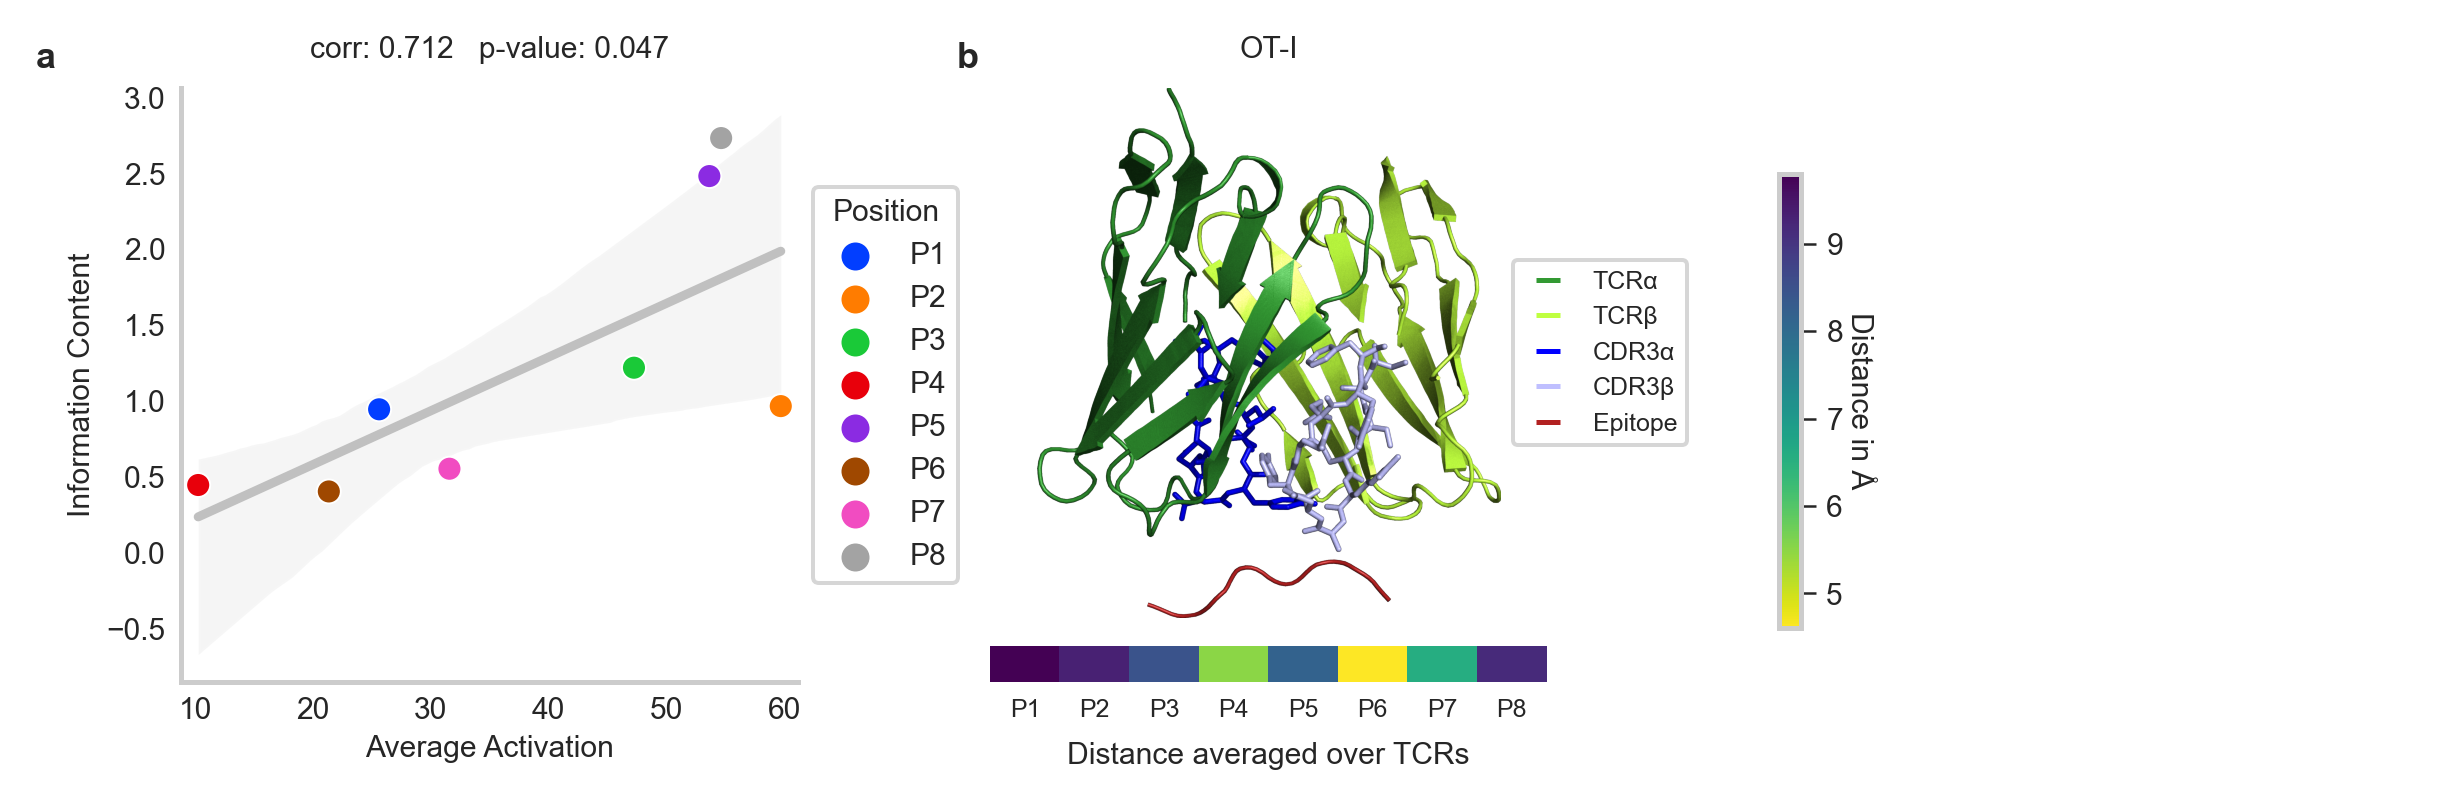

In [37]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.33), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=4,
    width_ratios=[1, 0.9, 0.25, 0.55]
)

gs2 = mpl.gridspec.GridSpecFromSubplotSpec(
    subplot_spec=gs[1],
    nrows=2,
    ncols=1,
    height_ratios=[15, 1],
    width_ratios=[1],
    hspace=0.1,
)

ax = fig.add_subplot(gs[0])
plot_correlation(df_corr_h2kb, ax)

ax = fig.add_subplot(gs2[0])
plot_3d_structures(ax, 'OT1', True)
ax.set_title('OT-I')

ax = fig.add_subplot(gs2[1])
plot_3d_distances(ax, 'avg', do_labels=True, legend_top=False)

ax = fig.add_subplot(gs[2])
plot_colorbar(ax, 'SIINFEKL', do_legend=False, do_left=False)

ax = fig.add_subplot(gs[3])
plot_empty(ax)

fig.text(0.0, 0.92, 'a', size='large', weight='bold')
fig.text(0.38, 0.92, 'b', size='large', weight='bold')
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_mhcCorr.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_mhcCorr.png', dpi=DPI, bbox_inches='tight')

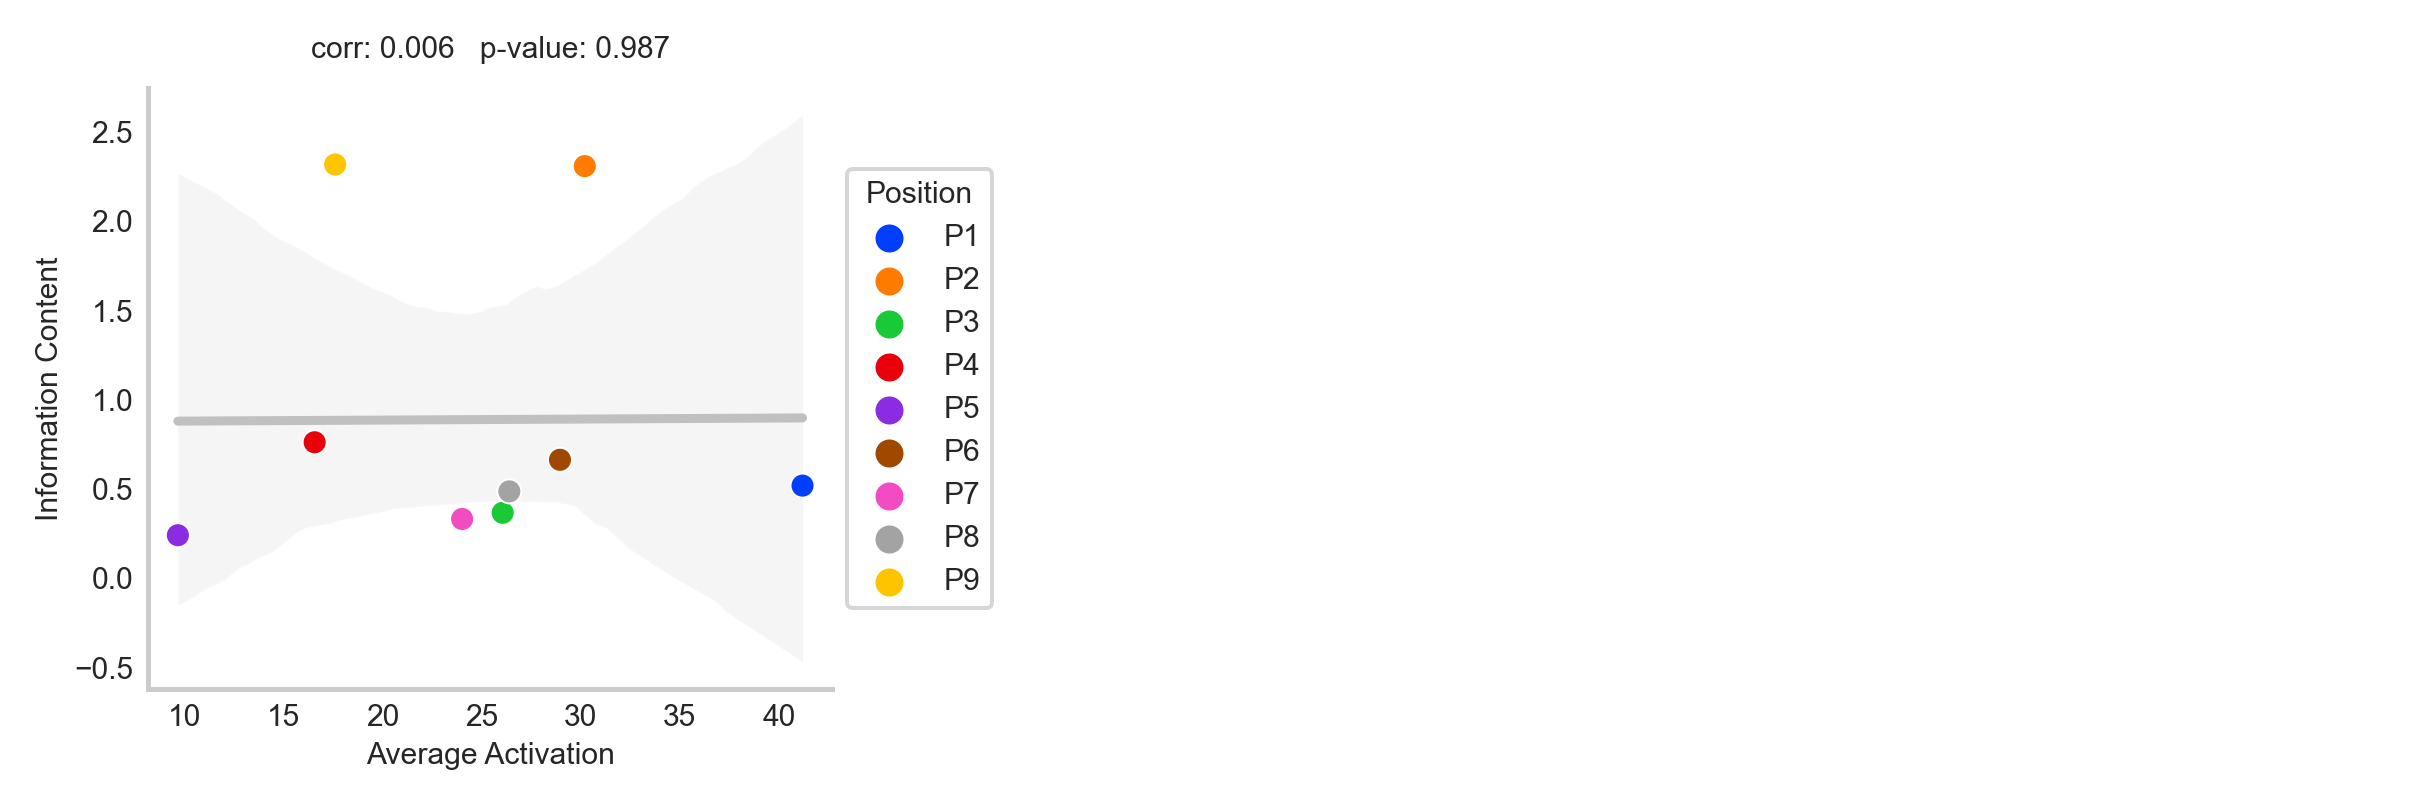

In [38]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.33), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=2,
    width_ratios=[1, 2]
)

ax = fig.add_subplot(gs[0])
plot_correlation(df_corr_a02, ax)

ax = fig.add_subplot(gs[1])
plot_empty(ax)
    
fig.tight_layout()
fig.savefig('figures/manuscript_supp_mhcCorrCMV.pdf', dpi=DPI, bbox_inches='tight')
fig.savefig('figures/manuscript_supp_mhcCorrCMV.png', dpi=DPI, bbox_inches='tight')

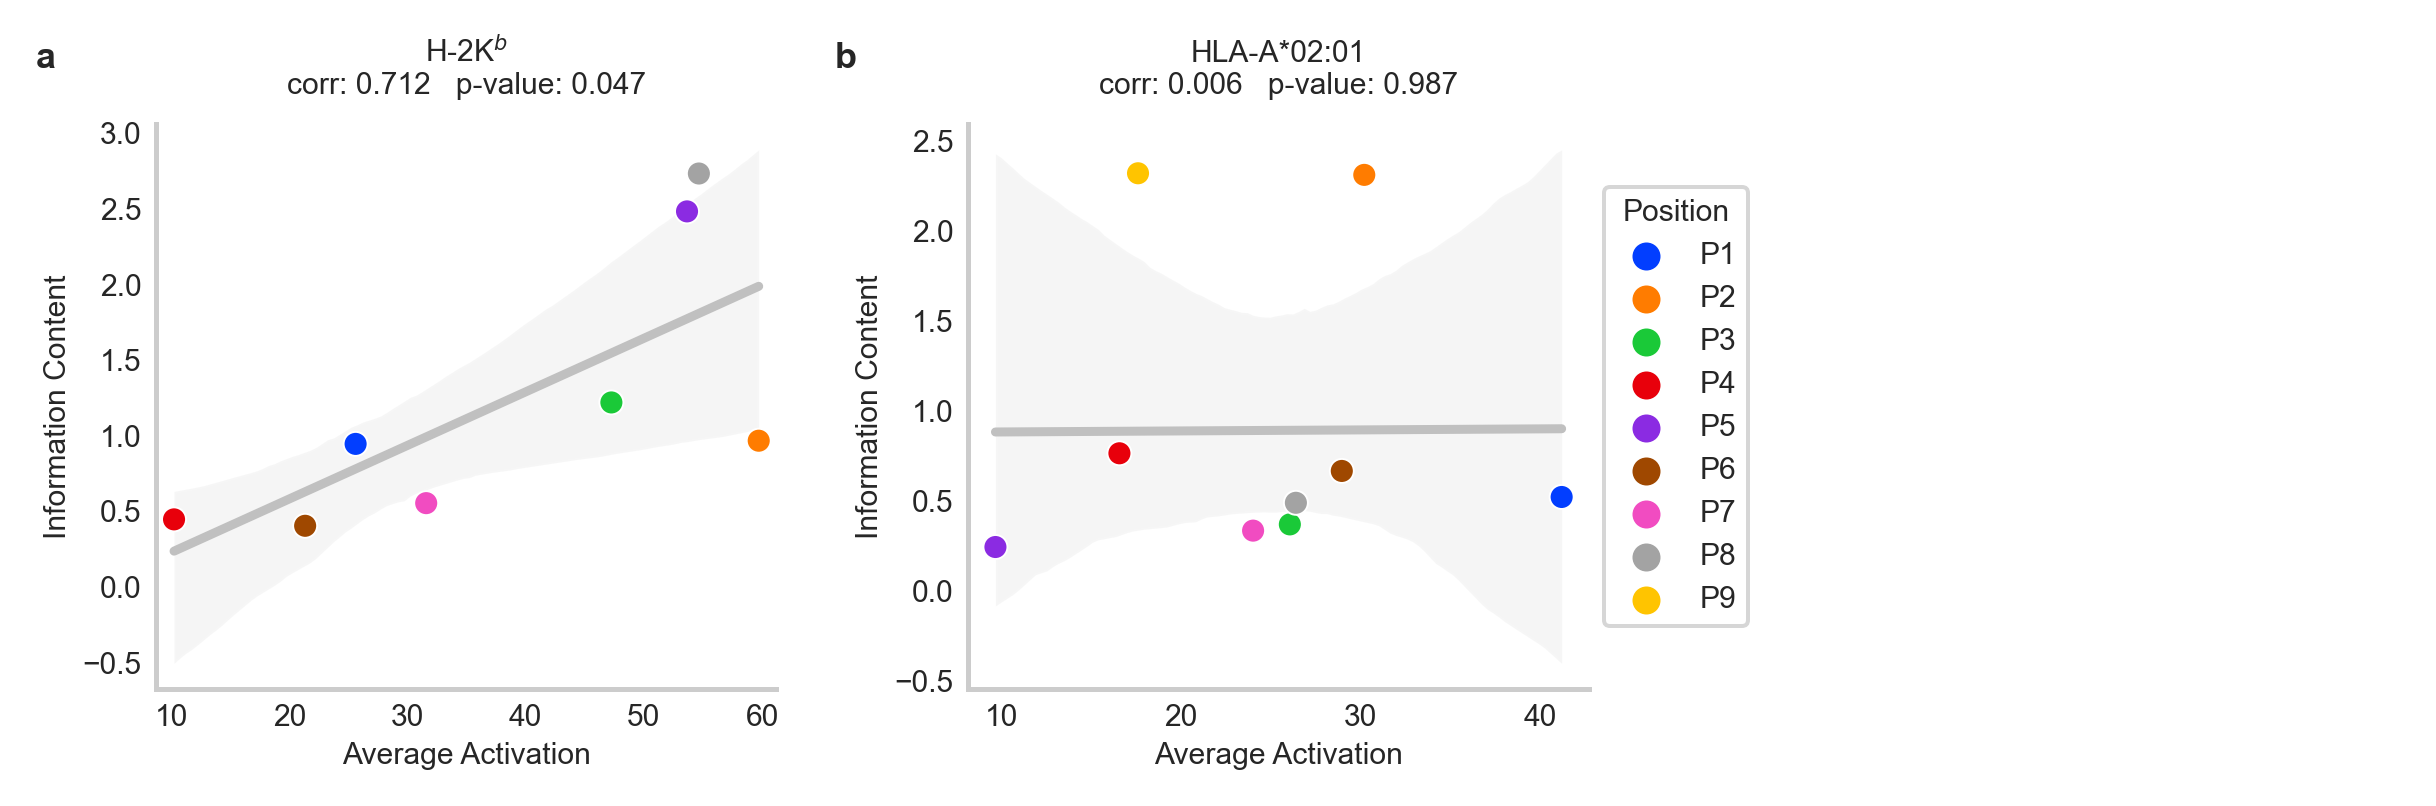

In [39]:
fig = plt.figure(figsize=(TEXTWIDTH, TEXTWIDTH * 0.33), dpi=DPI)
gridspecs = {}
axes = {}


gs = mpl.gridspec.GridSpec(
    figure=fig,
    nrows=1,
    ncols=3,
    width_ratios=[1, 1, 1]
)

ax = fig.add_subplot(gs[0])
plot_correlation(df_corr_h2kb, ax)
ax.legend().remove()
ax.set_title('H-2K$^{b}$\n'+ ax.get_title())

ax = fig.add_subplot(gs[1])
plot_correlation(df_corr_a02, ax)
ax.set_title(f'HLA-A*02:01\n{ax.get_title()}')

ax = fig.add_subplot(gs[2])
plot_empty(ax)

fig.text(0.01, 0.92, 'a', size='large', weight='bold')
fig.text(0.34, 0.92, 'b', size='large', weight='bold')
    
fig.tight_layout()
#fig.savefig('figures/manuscript_supp_mhcCorr_cmv.pdf', dpi=DPI, bbox_inches='tight')
#fig.savefig('figures/manuscript_supp_mhcCorr_cmv.png', dpi=DPI, bbox_inches='tight')